In [2]:
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt
from scipy import sparse

# Helper function
def diag_dom(n, num_entries=None, as_sparse=False):
    """Generate a strictly diagonally dominant (n, n) matrix.
Parameters:
n (int): The dimension of the system.
num_entries (int): The number of nonzero values.
Defaults to n^(3/2)-n.
as_sparse: If True, an equivalent sparse CSR matrix is returned.
Returns:
A ((n,n) ndarray): A (n, n) strictly diagonally dominant matrix.
    """
    if num_entries is None:
        num_entries = int(n**1.5) - n
    A = sparse.dok_matrix((n,n))
    rows = np.random.choice(n, size=num_entries)
    cols = np.random.choice(n, size=num_entries)
    data = np.random.randint(-4, 4, size=num_entries)
    for i in range(num_entries):
        A[rows[i], cols[i]] = data[i]
    B = A.tocsr()
    # convert to row format for the next step
    for i in range(n):
        A[i,i] = abs(B[i]).sum() + 1
    return A.tocsr() if as_sparse else A.toarray()

# Problems 1 and 2
def jacobi(A, b, tol=1e-8, maxiter=100, plot=False):
    """Calculate the solution to the system Ax = b via the Jacobi Method.

    Parameters:
        A ((n,n) ndarray): A square matrix.
        b ((n ,) ndarray): A vector of length n.
        tol (float): The convergence tolerance.
        maxiter (int): The maximum number of iterations to perform.

    Returns:
        ((n,) ndarray): The solution to system Ax = b.
    """
    iters = 0    #we will count the number of iterations so as to not exceed maxiter
    x0 = np.zeros(len(b))
    ds = np.diag(A)                    #create our matrix of Diagonals D and find the inverse
    d_in = 1/ds
    D_in = np.diag(d_in)
    abs_errs = []

    while iters < maxiter:
        x1 = x0 + D_in @ (b - A@x0)         #use formula 9.2
        iters += 1
        abs_errs.append(la.norm(x0 - x1, ord=np.inf))


        if la.norm(x0 - x1, ord=np.inf) < tol:        #test to see if vectors sufficiently close
            break

        x0 = x1

    if plot == True:             #if plot is true plot the convergence of the error on a semilog plot
        plt.semilogy(np.arange(iters), abs_errs)
        plt.title("Convergence of Jacobi Method")
        plt.xlabel("Iteration")
        plt.ylabel("Abs Error of Approximation")
        plt.show()
    return x1

def test1():
    b = np.random.random(20)
    A = diag_dom(20)
    x = jacobi(A, b)

    print(np.allclose(A@x, b))
test1()

True


In [3]:
# Problem 3
def gauss_seidel(A, b, tol=1e-8, maxiter=100, plot=False):
    """Calculate the solution to the system Ax = b via the Gauss-Seidel Method.

    Parameters:
        A ((n, n) ndarray): A square matrix.
        b ((n, ) ndarray): A vector of length n.
        tol (float): The convergence tolerance.
        maxiter (int): The maximum number of iterations to perform.
        plot (bool): If true, plot the convergence rate of the algorithm.

    Returns:
        x ((n,) ndarray): The solution to system Ax = b.
    """
    iters = 0               #keep track of the number of iterations
    abs_errs = []
    k = len(b)
    x0 = np.zeros(len(b))
    x1 = np.zeros(len(b))
    diags = 1/np.diag(A)


    while iters < maxiter:
        iters += 1
        for i in range(k):
            x1[i] = x1[i] + (diags[i] * (b[i] - A[i]@x1))         #edit the entries of the x1 as we go
        abs_errs.append(la.norm(x0 - x1, ord=np.inf))
        if la.norm(x0 - x1, ord=np.inf) < tol:        #test to see if vectors sufficiently close
            break
        
        x0 = np.copy(x1)

    if plot == True:             #if plot is true plot the convergence of the error on a semilog plot
        plt.semilogy(np.arange(iters), abs_errs)
        plt.title("Convergence of Gauss Seidel Method")
        plt.xlabel("Iteration")
        plt.ylabel("Abs Error of Approximation")
        plt.show()

    return x1

def test2():
    b = np.random.random(20)
    A = diag_dom(20)
    x = gauss_seidel(A, b)

    print(np.allclose(A@x, b))
test2()

True


In [5]:
# Problem 4
def gauss_seidel_sparse(A, b, tol=1e-8, maxiter=100):
    """Calculate the solution to the sparse system Ax = b via the Gauss-Seidel
    Method.

    Parameters:
        A ((n, n) csr_matrix): A (n, n) sparse CSR matrix.
        b ((n, ) ndarray): A vector of length n.
        tol (float): The convergence tolerance.
        maxiter (int): the maximum number of iterations to perform.

    Returns:
        x ((n,) ndarray): The solution to system Ax = b.
    """
    iters = 0               #keep track of the number of iterations
    k = len(b)
    x0 = np.zeros(len(b))
    x1 = np.zeros(len(b))
    diags = 1/A.diagonal()


    while iters < maxiter:
        iters += 1
        for i in range(k):
            rowstart = A.indptr[i]             #use the given method to calculate the inner product
            rowend = A.indptr[i+1]
            Aix = A.data[rowstart:rowend] @ x1[A.indices[rowstart:rowend]]
            x1[i] = x1[i] + (diags[i] * (b[i] - Aix))         #edit the entries of the x1 as we go

        if la.norm(x0 - x1, ord=np.inf) < tol:        #test to see if vectors sufficiently close
            break
        
        x0 = np.copy(x1)

    return x1
    
def test4():
    A = diag_dom(2000, as_sparse=True)
    b = np.random.random(2000)
    x = gauss_seidel_sparse(A,b)

    print(np.allclose(A@x, b))
test4()

True


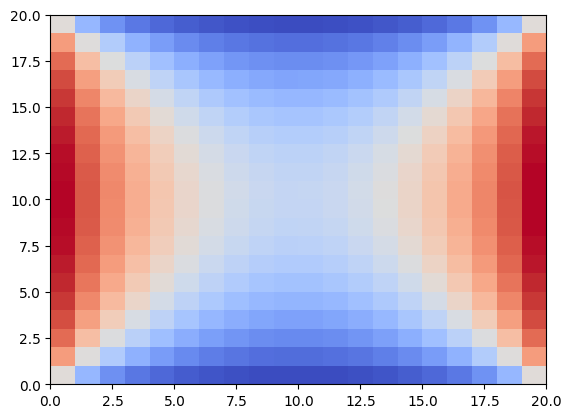

(array([49.76798382, 29.78990107, 20.31433119, 15.09178847, 11.88151653,
        9.77148981,  8.34558538,  7.39611911,  6.81370837,  6.54117346,
        6.55343119,  6.84973762,  7.45369942,  8.42105496,  9.85980858,
       11.9763626 , 15.18569446, 20.3988664 , 29.85590389, 49.80584584,
       69.30192912, 49.11131402, 36.42283553, 28.23047906, 22.73250241,
       18.93747935, 16.30045322, 14.51605128, 13.41150263, 12.89249209,
       12.91659418, 13.48234268, 14.62925373, 16.44880502, 19.11105775,
       22.91886931, 28.41495384, 36.58885761, 49.24090298, 69.37624507,
       78.36240321, 60.98746544, 48.11339978, 38.77229195, 31.99500205,
       27.07422202, 23.5427669 , 21.10433165, 19.57673937, 18.85501043,
       18.89028798, 19.68042106, 21.26999971, 23.75984549, 27.32816974,
       32.26760296, 39.04206173, 48.35612247, 61.17687145, 78.47099185,
       83.20727509, 68.44078002, 56.37785148, 46.88322822, 39.55681716,
       33.99669495, 29.88231456, 26.98288786, 25.14354502, 24.2

In [10]:
# Problem 5
def hot_plate(n, omega, tol=1e-8, maxiter=100, plot=False):
    """Generate the system Au = b and then solve it using sor().
    If show is True, visualize the solution with a heatmap.

    Parameters:
        n (int): Determines the size of A and b.
            A is (n^2, n^2) and b is one-dimensional with n^2 entries.
        omega (float in [0,1]): The relaxation factor.
        tol (float): The iteration tolerance.
        maxiter (int): The maximum number of iterations.
        plot (bool): Whether or not to visualize the solution.

    Returns:
        ((n^2,) ndarray): The 1-D solution vector u of the system Au = b.
        (bool): Whether or not Newton's method converged.
        (int): The number of computed iterations in SOR.
    """
    B = sparse.diags(diagonals=[[1], [-4], [1]], offsets=[-1, 0, 1], shape = (n,n))           #here we make our B matrix by creating diagonals and offsetting them to the correct positions

    A = sparse.block_diag([B]*n)                                         #here we create a block sparse diagonal matrix with our B matrix on the diagonal

    A.setdiag([1]*n*(n-1),n)                                              #here we set the positive offset of the diagonal of the block matrix to the identity matrices
    A.setdiag([1]*n*(n-1), -n)   

    A = sparse.csr_matrix(A)  

    sing = np.zeros(n)                   #create our b in the system of equations
    sing[0] = -100
    sing[-1] = -100
    b = np.tile(sing, n)

    sol = sor(A, b, omega, tol, maxiter)          #calculate the solution to the system using problem 6

    if plot == True:
        psol = sol[0].reshape((n,n))
        plt.pcolormesh(psol, cmap="coolwarm")                           #plot on colormesh map
        plt.show()

    return sol

def test5():
    print(hot_plate(20, omega= 1, plot=True))
test6()

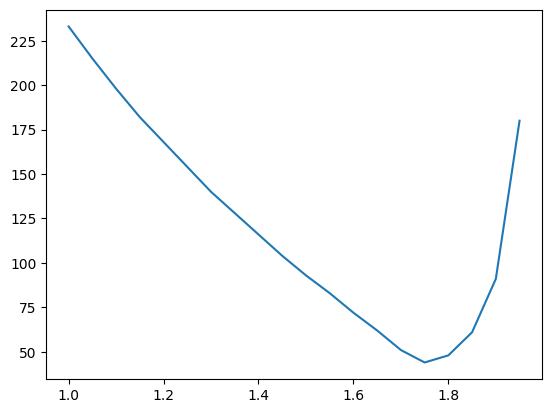

1.75

In [11]:
# Problem 6
def prob6():
    """Run hot_plate() with omega = 1, 1.05, 1.1, ..., 1.9, 1.95, tol=1e-2,
    and maxiter = 1000 with A and b generated with n=20. Plot the iterations
    computed as a function of omega.
    """
    omegas = np.linspace(1, 1.95, 20)              #make an array of omegas
    comp_iters = [] 

    for omega in omegas:
        comp_iters.append(hot_plate(20, omega, tol=1e-2, maxiter=1000, plot=False)[2])         #calculate the iterations for each omega value

    plt.plot(omegas, comp_iters)              #plot the results
    plt.show()

    best_om = omegas[np.argmin(comp_iters)]                #return the ideal omega

    return best_om
prob6()